#### Import Modules

In [3]:
import sys
print(sys.executable)

C:\ProgramData\Anaconda3\envs\detectron2-audio-segmenter\python.exe


In [4]:
# import some common libraries
import numpy as np
import cv2
import random
import colabtools

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

ModuleNotFoundError: No module named 'detectron2'

In [5]:
# more common libraries for retrieving data
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import audioread
import json
import os
import itertools
from PIL import Image
import cv2

C:\ProgramData\Anaconda3\envs\detectron2-audio-segmenter\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\ProgramData\Anaconda3\envs\detectron2-audio-segmenter\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


#### Preprocessing Functions

In [3]:
# return 3 self similarity matrices
def get_3ssm(audio_path):

    # load audio into np array
    y,sr = librosa.load(audio_path)
    
    #using these characteristics to achieve ~5 fps
    hop_length =  8192 
    n_fft = 16384

    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    # we can change the hop and fft size to get a matrix i dont need to change
    
    #compute chroma features and ssm
    chroma = librosa.feature.chroma_stft(S=S)
    ssm_chroma = librosa.segment.recurrence_matrix(chroma, metric='cosine', mode='affinity')

    #compute mel-spec features and ssm
    mel_spec = librosa.feature.melspectrogram(S=S)
    ssm_melspec = librosa.segment.recurrence_matrix(mel_spec, metric ='cosine', mode='affinity')
    
    #compute mfcc from mel-spec
    mfcc = librosa.feature.mfcc(S=mel_spec)
    ssm_mfcc = librosa.segment.recurrence_matrix(mfcc, metric='cosine', mode='affinity')
    print(ssm_mfcc.shape)

    return ssm_mfcc, ssm_chroma, ssm_melspec



# compress SSMs into png format
def ssm_to_png(mfcc, chroma, melspec, out_path):
    
    rgbArray = np.zeros((mfcc.shape[0],mfcc.shape[1],3), 'uint8')
    
    rgbArray[..., 0] = (mfcc/mfcc.max())*255
    rgbArray[..., 1] = (chroma/chroma.max())*255
    rgbArray[..., 2] = (melspec/melspec.max())*255
    
    
    print(rgbArray.shape)
    
    img = Image.fromarray(rgbArray)
    img.save(out_path)
    
# return bounding box of chorus, verse, and intro labels of jams dataset    
def get_bbox(anno_path):
    
    # open file
    with open(anno_path) as a:
        data = json.load(a)    

    # check through all annotations and count segment labels    
    obj_list = []
    
    for annotation in data['annotations']:
        
        chorus = []
        verse = []
        intro = []
        segments = []

        for segment in annotation['data']:
            if segment['value'] == "chorus":
                chorus.append([segment['time'], segment["duration"]])
            elif segment['value'] == "verse":
                verse.append([segment['time'], segment["duration"]])
            elif segment['value'] == "intro":
                intro.append([segment['time'], segment["duration"]])

        segments.append(chorus)
        segments.append(verse)
        segments.append(intro)

        colors = ['r','g','b']
        c = 0
        scale = (44100/8192)/2
        for seglabels in segments:
            segcombos = itertools.product(seglabels, repeat=2)
            
            # get the segment combination bounding boxes
            for combo in segcombos:
                
                rect =  patches.Rectangle((combo[0][0]*scale, combo[1][0]*scale), combo[0][1]*scale, combo[1][1]*scale, linewidth=1,edgecolor = colors[c], facecolor = 'none')
                bound = rect.get_bbox()
             
                xcount = int(round((bound.x1-bound.x0)/0.5))
                ycount = int(round((bound.y1-bound.y0)/0.5))
                px = np.linspace(bound.x0, bound.x1, xcount)
                py = np.linspace(bound.y0, bound.y1, ycount)

                poly1 = [(bound.x0, y) for y in py]
                poly2 = [(bound.x1, y) for y in py]
                poly3 = [(x, bound.y0) for x in px]
                poly4 = [(x, bound.y1) for x in px]

                newpoly = np.concatenate((poly1, poly2, poly3, poly4))
                newpoly = np.array(list(np.hstack(newpoly)))
                newpoly = (np.transpose(newpoly.reshape((np.shape(newpoly)[0],1)))).tolist()
                
                obj = {
                    "bbox": [bound.x0, bound.y0, bound.x1, bound.y1],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": newpoly,
                    "category_id": c,
                }
                obj_list.append(obj)
                
            c = c+1
    return obj_list

In [4]:
# return data in detectron dataset format
def get_audio_dicts(ds_dir):
    
    annos = '/home/shared/cuzokwe/datasets/SALAMI/references/'
    audio = ds_dir + 'audio'
    
    dataset_annos = []
    # Parse through available audio tags
    for file in os.listdir(audio):
        anno = annos +'SALAMI_' + file.split(".")[0] + '.jams'
        print('audio file: ' + file.split(".")[0])
        if os.path.exists(anno):
            record = {}
            
            img = ds_dir + "/images/"+ file.split(".")[0] + '.png'
            if os.path.exists(img):
                record["file_name"] = img
            else:
                mfcc, chroma, melspec = get_3ssm(audio + '/' + file.split(".")[0] + '.wav')
                ssm_to_png(mfcc, chroma, melspec, img)
                
                
                record["file_name"] = img                
            
            record["image_id"] = int(file.split(".")[0])
            
            img = cv2.imread(img)
            dimensions = img.shape
            record["height"] = dimensions[0]
            record["width"] = dimensions[1]
        
            
            objs = get_bbox(anno)
            record["annotations"] = objs
            
        
        dataset_annos.append(record)
    return dataset_annos     

#### Register Catalog and Visualize Data

In [5]:
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
ds_train = '/home/shared/cuzokwe/train/'
ds_val = '/home/shared/cuzokwe/val/'

In [6]:
# register training set data and metadata
DatasetCatalog.register("salami_2020_img_train", lambda ds_train=ds_train: get_audio_dicts(ds_train))
MetadataCatalog.get("salami_2020_img_train").thing_classes = ["chorus", "verse","intro"]

In [7]:
# register validation set data and metadata
DatasetCatalog.register("salami_2020_img_val", lambda ds_val=ds_val: get_audio_dicts(ds_val))
MetadataCatalog.get("salami_2020_img_val").thing_classes = ["chorus", "verse","intro"]

In [8]:
# unregister dataset
#DatasetCatalog.clear()

In [9]:
# show registered datasets
DatasetCatalog.list()

['coco_2014_train',
 'coco_2014_val',
 'coco_2014_minival',
 'coco_2014_minival_100',
 'coco_2014_valminusminival',
 'coco_2017_train',
 'coco_2017_val',
 'coco_2017_test',
 'coco_2017_test-dev',
 'coco_2017_val_100',
 'keypoints_coco_2014_train',
 'keypoints_coco_2014_val',
 'keypoints_coco_2014_minival',
 'keypoints_coco_2014_valminusminival',
 'keypoints_coco_2014_minival_100',
 'keypoints_coco_2017_train',
 'keypoints_coco_2017_val',
 'keypoints_coco_2017_val_100',
 'coco_2017_train_panoptic_separated',
 'coco_2017_train_panoptic_stuffonly',
 'coco_2017_val_panoptic_separated',
 'coco_2017_val_panoptic_stuffonly',
 'coco_2017_val_100_panoptic_separated',
 'coco_2017_val_100_panoptic_stuffonly',
 'lvis_v0.5_train',
 'lvis_v0.5_val',
 'lvis_v0.5_val_rand_100',
 'lvis_v0.5_test',
 'lvis_v0.5_train_cocofied',
 'lvis_v0.5_val_cocofied',
 'cityscapes_fine_instance_seg_train',
 'cityscapes_fine_sem_seg_train',
 'cityscapes_fine_instance_seg_val',
 'cityscapes_fine_sem_seg_val',
 'cityscap

In [10]:
dataset_dicts_train = get_audio_dicts(ds_train)
dataset_dicts_val = get_audio_dicts(ds_val)

audio file: 355
audio file: 343
audio file: 411
audio file: 930
audio file: 618
audio file: 639
audio file: 636
audio file: 268
audio file: 67
audio file: 495
audio file: 79
audio file: 236
audio file: 651
audio file: 82
audio file: 770
audio file: 332
audio file: 510
audio file: 700
audio file: 675
audio file: 757
audio file: 936
audio file: 154
audio file: 399
audio file: 468
audio file: 536
audio file: 440
audio file: 842
audio file: 658
audio file: 880
audio file: 32
audio file: 107
audio file: 186
audio file: 899
audio file: 720
audio file: 844
audio file: 596
audio file: 364
audio file: 498
audio file: 725
audio file: 482
audio file: 458
audio file: 146
audio file: 599
audio file: 728
audio file: 315
audio file: 397
audio file: 696
audio file: 128
audio file: 634
audio file: 506
audio file: 772
audio file: 218
audio file: 591
audio file: 855
audio file: 503
audio file: 723
audio file: 952
audio file: 831
audio file: 659
audio file: 549
audio file: 48
audio file: 707
audio file: 2

(531, 531)
(531, 531, 3)
audio file: 419
audio file: 706
(863, 863)
(863, 863, 3)
audio file: 910
(529, 529)
(529, 529, 3)
audio file: 678
(1594, 1594)
(1594, 1594, 3)
audio file: 1624
(830, 830)
(830, 830, 3)
audio file: 786
(395, 395)
(395, 395, 3)
audio file: 375
audio file: 1615
(679, 679)
(679, 679, 3)
audio file: 354
(149, 149)
(149, 149, 3)
audio file: 1652
(768, 768)
(768, 768, 3)
audio file: 183
(434, 434)
(434, 434, 3)
audio file: 783
(598, 598)
(598, 598, 3)
audio file: 326
(602, 602)
(602, 602, 3)
audio file: 939
(979, 979)
(979, 979, 3)
audio file: 938
(578, 578)
(578, 578, 3)
audio file: 294
(373, 373)
(373, 373, 3)
audio file: 378
(95, 95)
(95, 95, 3)
audio file: 719
(41, 41)
(41, 41, 3)
audio file: 182
audio file: 522
(728, 728)
(728, 728, 3)
audio file: 934
(1278, 1278)
(1278, 1278, 3)
audio file: 632
(863, 863)
(863, 863, 3)
audio file: 413
audio file: 191
audio file: 835
(355, 355)
(355, 355, 3)
audio file: 1634
(432, 432)
(432, 432, 3)
audio file: 951
(461, 461)
(46

(750, 750, 3)
/home/shared/cuzokwe/train//images/27.png


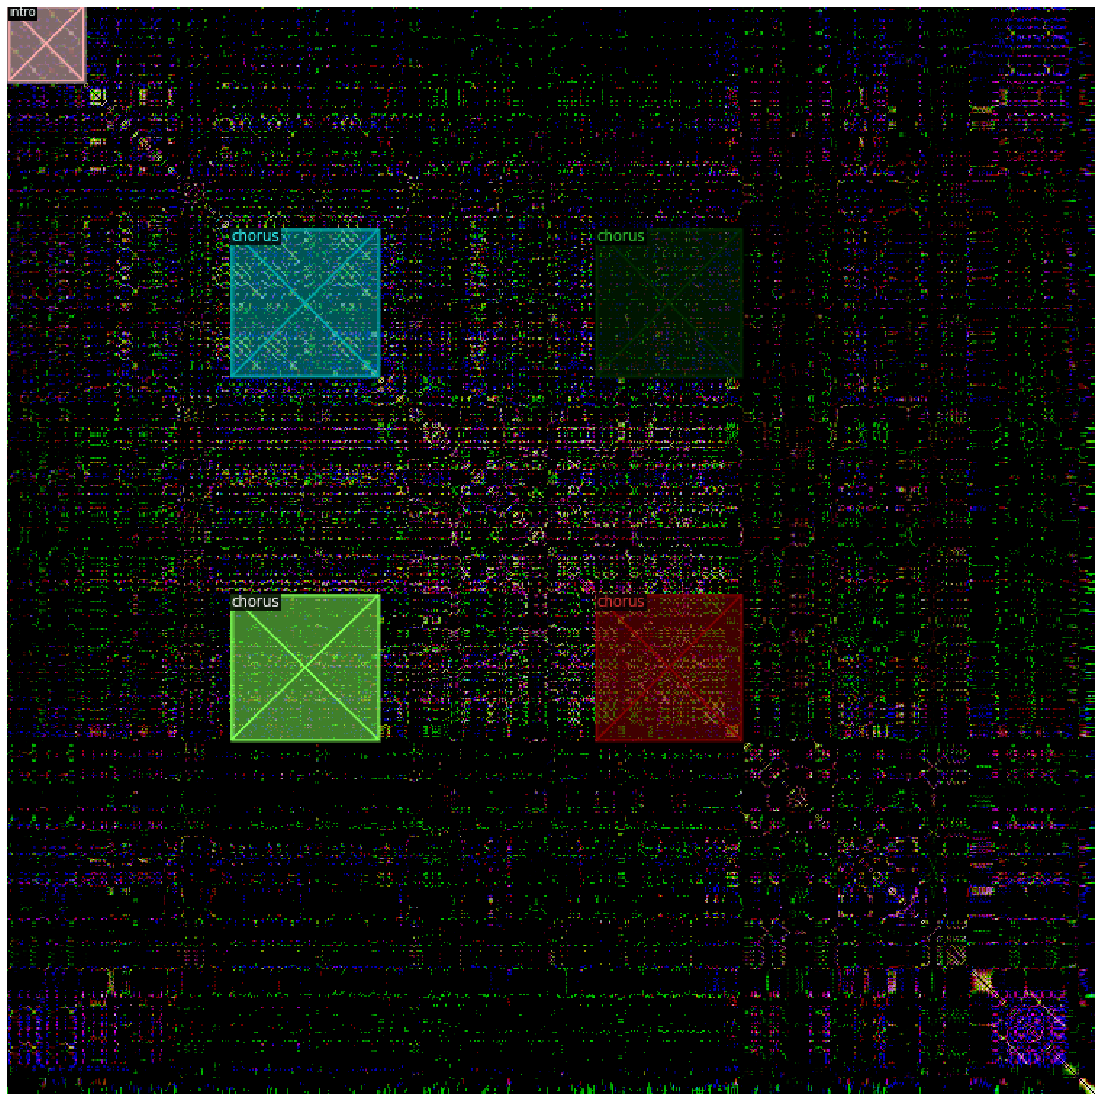

(673, 673, 3)
/home/shared/cuzokwe/train//images/802.png


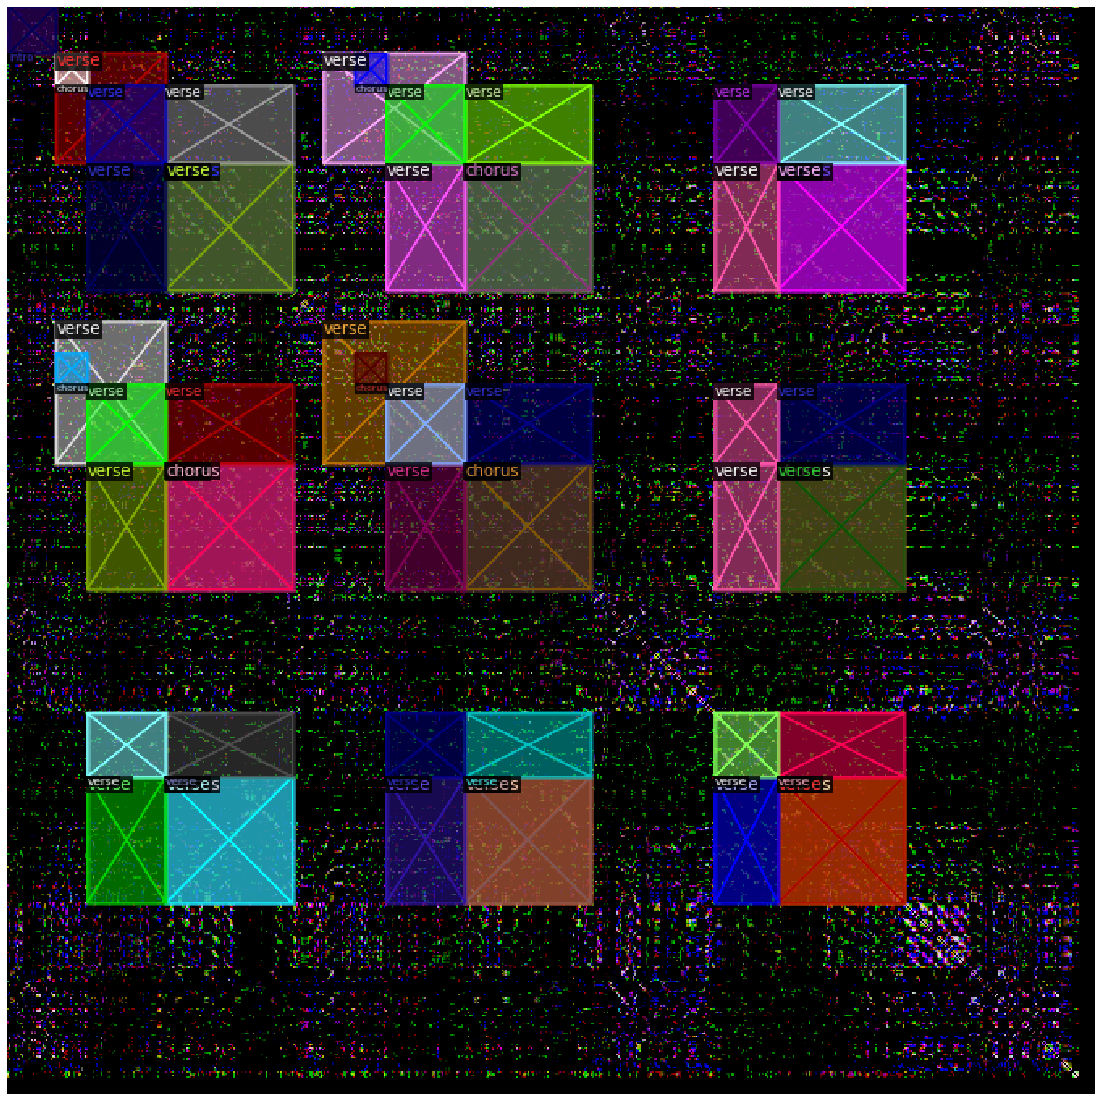

(129, 129, 3)
/home/shared/cuzokwe/train//images/176.png


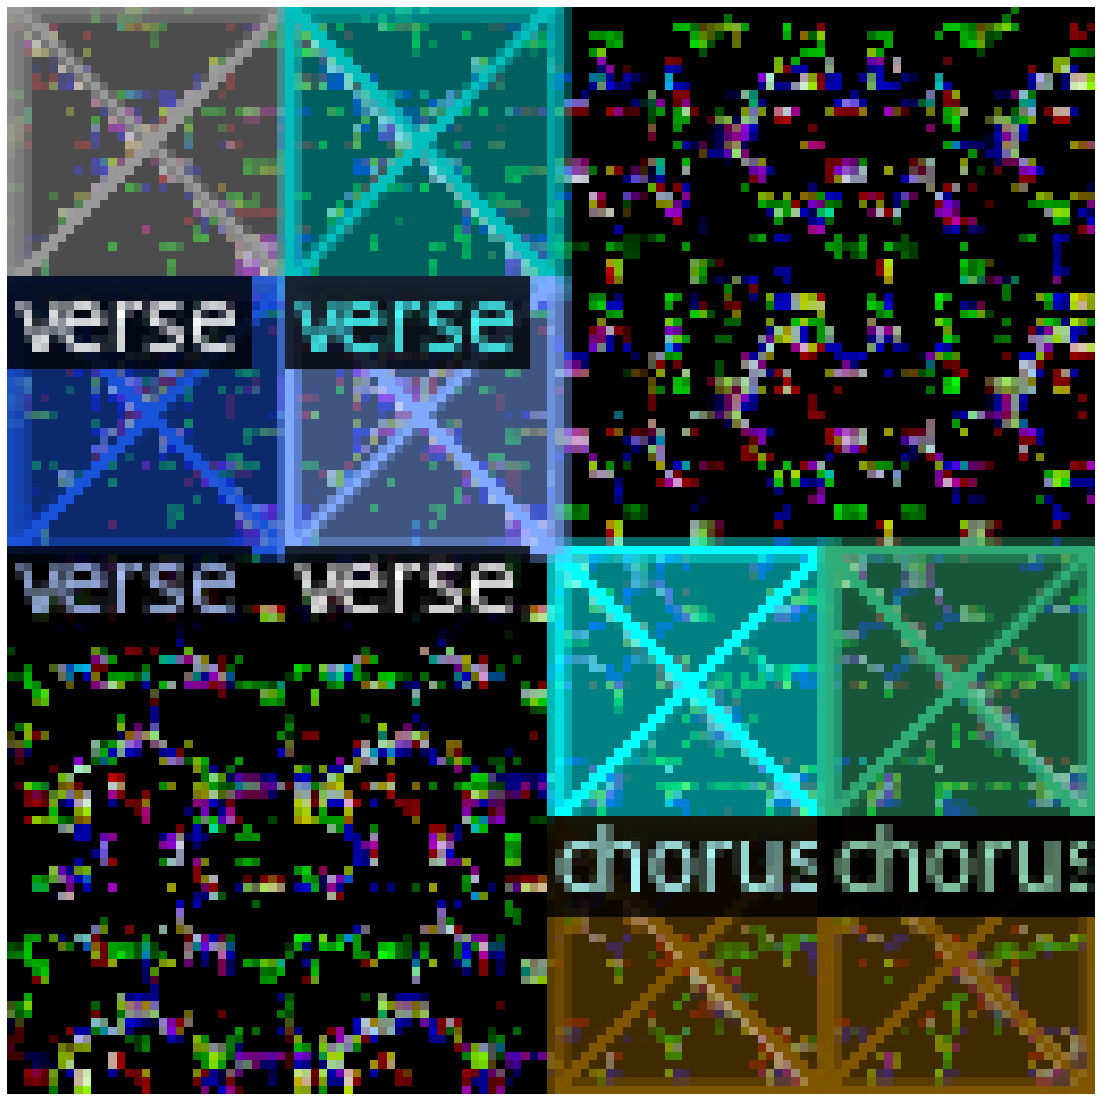

In [11]:
audio_metadata = MetadataCatalog.get("salami_2020_img_train")
for d in random.sample(dataset_dicts_train, 3):
    img = cv2.imread(d["file_name"])
    print(img.shape)
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=audio_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(20,20))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()


### Train the Model

In [33]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("salami_2020_img_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0005  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/16 20:59:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

audio file: 355
audio file: 343
audio file: 411
audio file: 930
audio file: 618
audio file: 639
audio file: 636
audio file: 268
audio file: 67
audio file: 495
audio file: 79
audio file: 236
audio file: 651
audio file: 82
audio file: 770
audio file: 332
audio file: 510
audio file: 700
audio file: 675
audio file: 757
audio file: 936
audio file: 154
audio file: 399
audio file: 468
audio file: 536
audio file: 440
audio file: 842
audio file: 658
audio file: 880
audio file: 32
audio file: 107
audio file: 186
audio file: 899
audio file: 720
audio file: 844
audio file: 596
audio file: 364
audio file: 498
audio file: 725
audio file: 482
audio file: 458
audio file: 146
audio file: 599
audio file: 728
audio file: 315
audio file: 397
audio file: 696
audio file: 128
audio file: 634
audio file: 506
audio file: 772
audio file: 218
audio file: 591
audio file: 855
audio file: 503
audio file: 723
audio file: 952
audio file: 831
audio file: 659
audio file: 549
audio file: 48
audio file: 707
audio file: 2

[04/16 21:00:22 d2.data.build]: Using training sampler TrainingSampler


'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (12, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (12,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (3,) in the model! Skipped.


[04/16 21:00:22 d2.engine.train_loop]: Starting training from iteration 0
[04/16 21:00:27 d2.utils.events]:  eta: 0:39:22  iter: 19  total_loss: 4.941  loss_cls: 1.447  loss_box_reg: 0.150  loss_mask: 0.689  loss_rpn_cls: 2.376  loss_rpn_loc: 0.226  time: 0.2339  data_time: 0.0236  lr: 0.000010  max_mem: 3247M
[04/16 21:00:32 d2.utils.events]:  eta: 0:38:41  iter: 39  total_loss: 3.394  loss_cls: 1.271  loss_box_reg: 0.238  loss_mask: 0.683  loss_rpn_cls: 1.003  loss_rpn_loc: 0.253  time: 0.2356  data_time: 0.0103  lr: 0.000020  max_mem: 3247M
[04/16 21:00:37 d2.utils.events]:  eta: 0:39:15  iter: 59  total_loss: 2.795  loss_cls: 1.006  loss_box_reg: 0.426  loss_mask: 0.677  loss_rpn_cls: 0.381  loss_rpn_loc: 0.153  time: 0.2390  data_time: 0.0113  lr: 0.000030  max_mem: 3247M
[04/16 21:00:42 d2.utils.events]:  eta: 0:39:50  iter: 79  total_loss: 2.654  loss_cls: 0.829  loss_box_reg: 0.401  loss_mask: 0.661  loss_rpn_cls: 0.448  loss_rpn_loc: 0.178  time: 0.2434  data_time: 0.0183  lr:

[04/16 21:03:12 d2.utils.events]:  eta: 0:38:07  iter: 679  total_loss: 1.784  loss_cls: 0.540  loss_box_reg: 0.497  loss_mask: 0.314  loss_rpn_cls: 0.201  loss_rpn_loc: 0.102  time: 0.2467  data_time: 0.0109  lr: 0.000340  max_mem: 3254M
[04/16 21:03:17 d2.utils.events]:  eta: 0:38:01  iter: 699  total_loss: 1.972  loss_cls: 0.601  loss_box_reg: 0.601  loss_mask: 0.325  loss_rpn_cls: 0.198  loss_rpn_loc: 0.146  time: 0.2464  data_time: 0.0115  lr: 0.000350  max_mem: 3254M
[04/16 21:03:22 d2.utils.events]:  eta: 0:37:57  iter: 719  total_loss: 1.927  loss_cls: 0.590  loss_box_reg: 0.538  loss_mask: 0.309  loss_rpn_cls: 0.221  loss_rpn_loc: 0.098  time: 0.2465  data_time: 0.0106  lr: 0.000360  max_mem: 3254M
[04/16 21:03:27 d2.utils.events]:  eta: 0:37:52  iter: 739  total_loss: 1.924  loss_cls: 0.619  loss_box_reg: 0.589  loss_mask: 0.315  loss_rpn_cls: 0.230  loss_rpn_loc: 0.101  time: 0.2464  data_time: 0.0153  lr: 0.000370  max_mem: 3254M
[04/16 21:03:32 d2.utils.events]:  eta: 0:37

[04/16 21:05:59 d2.utils.events]:  eta: 0:35:45  iter: 1339  total_loss: 2.032  loss_cls: 0.623  loss_box_reg: 0.604  loss_mask: 0.302  loss_rpn_cls: 0.265  loss_rpn_loc: 0.188  time: 0.2484  data_time: 0.0277  lr: 0.000500  max_mem: 3254M
[04/16 21:06:04 d2.utils.events]:  eta: 0:35:43  iter: 1359  total_loss: 1.548  loss_cls: 0.501  loss_box_reg: 0.495  loss_mask: 0.284  loss_rpn_cls: 0.159  loss_rpn_loc: 0.115  time: 0.2485  data_time: 0.0107  lr: 0.000500  max_mem: 3254M
[04/16 21:06:09 d2.utils.events]:  eta: 0:35:38  iter: 1379  total_loss: 1.657  loss_cls: 0.537  loss_box_reg: 0.452  loss_mask: 0.303  loss_rpn_cls: 0.198  loss_rpn_loc: 0.108  time: 0.2485  data_time: 0.0101  lr: 0.000500  max_mem: 3254M
[04/16 21:06:14 d2.utils.events]:  eta: 0:35:34  iter: 1399  total_loss: 1.631  loss_cls: 0.499  loss_box_reg: 0.470  loss_mask: 0.296  loss_rpn_cls: 0.227  loss_rpn_loc: 0.122  time: 0.2485  data_time: 0.0109  lr: 0.000500  max_mem: 3254M
[04/16 21:06:19 d2.utils.events]:  eta: 

[04/16 21:08:45 d2.utils.events]:  eta: 0:33:09  iter: 1999  total_loss: 1.458  loss_cls: 0.478  loss_box_reg: 0.419  loss_mask: 0.260  loss_rpn_cls: 0.130  loss_rpn_loc: 0.082  time: 0.2488  data_time: 0.0258  lr: 0.000500  max_mem: 3255M
[04/16 21:08:51 d2.utils.events]:  eta: 0:33:08  iter: 2019  total_loss: 1.621  loss_cls: 0.547  loss_box_reg: 0.509  loss_mask: 0.304  loss_rpn_cls: 0.159  loss_rpn_loc: 0.106  time: 0.2488  data_time: 0.0115  lr: 0.000500  max_mem: 3255M
[04/16 21:08:55 d2.utils.events]:  eta: 0:33:03  iter: 2039  total_loss: 1.306  loss_cls: 0.446  loss_box_reg: 0.390  loss_mask: 0.269  loss_rpn_cls: 0.114  loss_rpn_loc: 0.070  time: 0.2488  data_time: 0.0108  lr: 0.000500  max_mem: 3255M
[04/16 21:09:01 d2.utils.events]:  eta: 0:32:58  iter: 2059  total_loss: 1.573  loss_cls: 0.528  loss_box_reg: 0.461  loss_mask: 0.284  loss_rpn_cls: 0.138  loss_rpn_loc: 0.108  time: 0.2489  data_time: 0.0305  lr: 0.000500  max_mem: 3255M
[04/16 21:09:06 d2.utils.events]:  eta: 

[04/16 21:11:33 d2.utils.events]:  eta: 0:30:30  iter: 2659  total_loss: 1.503  loss_cls: 0.473  loss_box_reg: 0.436  loss_mask: 0.261  loss_rpn_cls: 0.117  loss_rpn_loc: 0.109  time: 0.2493  data_time: 0.0294  lr: 0.000500  max_mem: 3255M
[04/16 21:11:38 d2.utils.events]:  eta: 0:30:24  iter: 2679  total_loss: 1.521  loss_cls: 0.521  loss_box_reg: 0.442  loss_mask: 0.252  loss_rpn_cls: 0.181  loss_rpn_loc: 0.097  time: 0.2493  data_time: 0.0116  lr: 0.000500  max_mem: 3255M
[04/16 21:11:43 d2.utils.events]:  eta: 0:30:19  iter: 2699  total_loss: 1.494  loss_cls: 0.434  loss_box_reg: 0.429  loss_mask: 0.263  loss_rpn_cls: 0.145  loss_rpn_loc: 0.102  time: 0.2493  data_time: 0.0260  lr: 0.000500  max_mem: 3255M
[04/16 21:11:48 d2.utils.events]:  eta: 0:30:14  iter: 2719  total_loss: 1.497  loss_cls: 0.462  loss_box_reg: 0.448  loss_mask: 0.264  loss_rpn_cls: 0.174  loss_rpn_loc: 0.111  time: 0.2493  data_time: 0.0113  lr: 0.000500  max_mem: 3255M
[04/16 21:11:53 d2.utils.events]:  eta: 

[04/16 21:14:20 d2.utils.events]:  eta: 0:27:43  iter: 3319  total_loss: 1.411  loss_cls: 0.461  loss_box_reg: 0.395  loss_mask: 0.253  loss_rpn_cls: 0.142  loss_rpn_loc: 0.077  time: 0.2498  data_time: 0.0109  lr: 0.000500  max_mem: 3255M
[04/16 21:14:25 d2.utils.events]:  eta: 0:27:38  iter: 3339  total_loss: 1.494  loss_cls: 0.497  loss_box_reg: 0.426  loss_mask: 0.256  loss_rpn_cls: 0.157  loss_rpn_loc: 0.098  time: 0.2498  data_time: 0.0115  lr: 0.000500  max_mem: 3255M
[04/16 21:14:31 d2.utils.events]:  eta: 0:27:34  iter: 3359  total_loss: 1.345  loss_cls: 0.454  loss_box_reg: 0.403  loss_mask: 0.246  loss_rpn_cls: 0.139  loss_rpn_loc: 0.097  time: 0.2498  data_time: 0.0294  lr: 0.000500  max_mem: 3255M
[04/16 21:14:36 d2.utils.events]:  eta: 0:27:29  iter: 3379  total_loss: 1.568  loss_cls: 0.483  loss_box_reg: 0.387  loss_mask: 0.246  loss_rpn_cls: 0.177  loss_rpn_loc: 0.118  time: 0.2498  data_time: 0.0099  lr: 0.000500  max_mem: 3255M
[04/16 21:14:41 d2.utils.events]:  eta: 

[04/16 21:17:08 d2.utils.events]:  eta: 0:24:56  iter: 3979  total_loss: 1.518  loss_cls: 0.444  loss_box_reg: 0.459  loss_mask: 0.244  loss_rpn_cls: 0.169  loss_rpn_loc: 0.126  time: 0.2499  data_time: 0.0215  lr: 0.000500  max_mem: 3255M
[04/16 21:17:13 d2.utils.events]:  eta: 0:24:51  iter: 3999  total_loss: 1.223  loss_cls: 0.364  loss_box_reg: 0.358  loss_mask: 0.227  loss_rpn_cls: 0.138  loss_rpn_loc: 0.082  time: 0.2499  data_time: 0.0091  lr: 0.000500  max_mem: 3255M
[04/16 21:17:18 d2.utils.events]:  eta: 0:24:45  iter: 4019  total_loss: 1.350  loss_cls: 0.455  loss_box_reg: 0.377  loss_mask: 0.248  loss_rpn_cls: 0.168  loss_rpn_loc: 0.116  time: 0.2499  data_time: 0.0099  lr: 0.000500  max_mem: 3255M
[04/16 21:17:23 d2.utils.events]:  eta: 0:24:40  iter: 4039  total_loss: 1.437  loss_cls: 0.464  loss_box_reg: 0.428  loss_mask: 0.232  loss_rpn_cls: 0.120  loss_rpn_loc: 0.100  time: 0.2499  data_time: 0.0101  lr: 0.000500  max_mem: 3255M
[04/16 21:17:28 d2.utils.events]:  eta: 

[04/16 21:19:55 d2.utils.events]:  eta: 0:22:12  iter: 4639  total_loss: 1.286  loss_cls: 0.401  loss_box_reg: 0.370  loss_mask: 0.244  loss_rpn_cls: 0.129  loss_rpn_loc: 0.100  time: 0.2501  data_time: 0.0103  lr: 0.000500  max_mem: 3255M
[04/16 21:20:01 d2.utils.events]:  eta: 0:22:07  iter: 4659  total_loss: 1.303  loss_cls: 0.413  loss_box_reg: 0.310  loss_mask: 0.218  loss_rpn_cls: 0.164  loss_rpn_loc: 0.103  time: 0.2502  data_time: 0.0311  lr: 0.000500  max_mem: 3255M
[04/16 21:20:05 d2.utils.events]:  eta: 0:22:02  iter: 4679  total_loss: 1.314  loss_cls: 0.416  loss_box_reg: 0.367  loss_mask: 0.216  loss_rpn_cls: 0.128  loss_rpn_loc: 0.085  time: 0.2502  data_time: 0.0115  lr: 0.000500  max_mem: 3255M
[04/16 21:20:10 d2.utils.events]:  eta: 0:21:57  iter: 4699  total_loss: 1.291  loss_cls: 0.423  loss_box_reg: 0.415  loss_mask: 0.237  loss_rpn_cls: 0.130  loss_rpn_loc: 0.088  time: 0.2501  data_time: 0.0107  lr: 0.000500  max_mem: 3255M
[04/16 21:20:15 d2.utils.events]:  eta: 

[04/16 21:22:47 d2.utils.events]:  eta: 0:19:29  iter: 5299  total_loss: 1.154  loss_cls: 0.350  loss_box_reg: 0.337  loss_mask: 0.187  loss_rpn_cls: 0.112  loss_rpn_loc: 0.103  time: 0.2502  data_time: 0.0113  lr: 0.000500  max_mem: 3255M
[04/16 21:22:52 d2.utils.events]:  eta: 0:19:24  iter: 5319  total_loss: 1.109  loss_cls: 0.343  loss_box_reg: 0.324  loss_mask: 0.219  loss_rpn_cls: 0.098  loss_rpn_loc: 0.079  time: 0.2502  data_time: 0.0096  lr: 0.000500  max_mem: 3255M
[04/16 21:22:57 d2.utils.events]:  eta: 0:19:19  iter: 5339  total_loss: 1.227  loss_cls: 0.418  loss_box_reg: 0.330  loss_mask: 0.227  loss_rpn_cls: 0.107  loss_rpn_loc: 0.099  time: 0.2503  data_time: 0.0158  lr: 0.000500  max_mem: 3255M
[04/16 21:23:02 d2.utils.events]:  eta: 0:19:15  iter: 5359  total_loss: 1.340  loss_cls: 0.407  loss_box_reg: 0.356  loss_mask: 0.242  loss_rpn_cls: 0.196  loss_rpn_loc: 0.112  time: 0.2503  data_time: 0.0324  lr: 0.000500  max_mem: 3255M
[04/16 21:23:07 d2.utils.events]:  eta: 

[04/16 21:25:33 d2.utils.events]:  eta: 0:16:45  iter: 5959  total_loss: 1.048  loss_cls: 0.287  loss_box_reg: 0.387  loss_mask: 0.226  loss_rpn_cls: 0.095  loss_rpn_loc: 0.072  time: 0.2502  data_time: 0.0108  lr: 0.000500  max_mem: 3255M
[04/16 21:25:38 d2.utils.events]:  eta: 0:16:40  iter: 5979  total_loss: 1.045  loss_cls: 0.313  loss_box_reg: 0.329  loss_mask: 0.208  loss_rpn_cls: 0.075  loss_rpn_loc: 0.105  time: 0.2502  data_time: 0.0341  lr: 0.000500  max_mem: 3255M
[04/16 21:25:43 d2.utils.events]:  eta: 0:16:36  iter: 5999  total_loss: 1.471  loss_cls: 0.439  loss_box_reg: 0.399  loss_mask: 0.203  loss_rpn_cls: 0.167  loss_rpn_loc: 0.126  time: 0.2503  data_time: 0.0111  lr: 0.000500  max_mem: 3255M
[04/16 21:25:49 d2.utils.events]:  eta: 0:16:32  iter: 6019  total_loss: 1.274  loss_cls: 0.388  loss_box_reg: 0.431  loss_mask: 0.225  loss_rpn_cls: 0.135  loss_rpn_loc: 0.104  time: 0.2503  data_time: 0.0306  lr: 0.000500  max_mem: 3255M
[04/16 21:25:54 d2.utils.events]:  eta: 

[04/16 21:28:24 d2.utils.events]:  eta: 0:14:11  iter: 6619  total_loss: 1.073  loss_cls: 0.362  loss_box_reg: 0.338  loss_mask: 0.221  loss_rpn_cls: 0.099  loss_rpn_loc: 0.077  time: 0.2508  data_time: 0.0121  lr: 0.000500  max_mem: 3255M
[04/16 21:28:29 d2.utils.events]:  eta: 0:14:05  iter: 6639  total_loss: 0.915  loss_cls: 0.279  loss_box_reg: 0.286  loss_mask: 0.191  loss_rpn_cls: 0.063  loss_rpn_loc: 0.073  time: 0.2508  data_time: 0.0152  lr: 0.000500  max_mem: 3255M
[04/16 21:28:34 d2.utils.events]:  eta: 0:13:59  iter: 6659  total_loss: 1.078  loss_cls: 0.383  loss_box_reg: 0.387  loss_mask: 0.212  loss_rpn_cls: 0.093  loss_rpn_loc: 0.094  time: 0.2508  data_time: 0.0098  lr: 0.000500  max_mem: 3255M
[04/16 21:28:39 d2.utils.events]:  eta: 0:13:54  iter: 6679  total_loss: 1.240  loss_cls: 0.385  loss_box_reg: 0.407  loss_mask: 0.209  loss_rpn_cls: 0.138  loss_rpn_loc: 0.112  time: 0.2508  data_time: 0.0106  lr: 0.000500  max_mem: 3255M
[04/16 21:28:44 d2.utils.events]:  eta: 

[04/16 21:31:13 d2.utils.events]:  eta: 0:11:28  iter: 7279  total_loss: 1.065  loss_cls: 0.296  loss_box_reg: 0.383  loss_mask: 0.205  loss_rpn_cls: 0.080  loss_rpn_loc: 0.081  time: 0.2511  data_time: 0.0113  lr: 0.000500  max_mem: 3255M
[04/16 21:31:18 d2.utils.events]:  eta: 0:11:22  iter: 7299  total_loss: 1.110  loss_cls: 0.331  loss_box_reg: 0.349  loss_mask: 0.214  loss_rpn_cls: 0.096  loss_rpn_loc: 0.077  time: 0.2511  data_time: 0.0174  lr: 0.000500  max_mem: 3255M
[04/16 21:31:24 d2.utils.events]:  eta: 0:11:17  iter: 7319  total_loss: 0.827  loss_cls: 0.245  loss_box_reg: 0.261  loss_mask: 0.165  loss_rpn_cls: 0.082  loss_rpn_loc: 0.046  time: 0.2511  data_time: 0.0093  lr: 0.000500  max_mem: 3255M
[04/16 21:31:29 d2.utils.events]:  eta: 0:11:12  iter: 7339  total_loss: 1.095  loss_cls: 0.329  loss_box_reg: 0.358  loss_mask: 0.201  loss_rpn_cls: 0.114  loss_rpn_loc: 0.085  time: 0.2511  data_time: 0.0121  lr: 0.000500  max_mem: 3255M
[04/16 21:31:34 d2.utils.events]:  eta: 

[04/16 21:34:03 d2.utils.events]:  eta: 0:08:39  iter: 7939  total_loss: 1.085  loss_cls: 0.322  loss_box_reg: 0.321  loss_mask: 0.208  loss_rpn_cls: 0.098  loss_rpn_loc: 0.088  time: 0.2513  data_time: 0.0531  lr: 0.000500  max_mem: 3255M
[04/16 21:34:08 d2.utils.events]:  eta: 0:08:34  iter: 7959  total_loss: 1.065  loss_cls: 0.309  loss_box_reg: 0.333  loss_mask: 0.198  loss_rpn_cls: 0.084  loss_rpn_loc: 0.096  time: 0.2513  data_time: 0.0107  lr: 0.000500  max_mem: 3255M
[04/16 21:34:13 d2.utils.events]:  eta: 0:08:29  iter: 7979  total_loss: 0.830  loss_cls: 0.231  loss_box_reg: 0.289  loss_mask: 0.178  loss_rpn_cls: 0.059  loss_rpn_loc: 0.064  time: 0.2513  data_time: 0.0299  lr: 0.000500  max_mem: 3255M
[04/16 21:34:18 d2.utils.events]:  eta: 0:08:24  iter: 7999  total_loss: 1.058  loss_cls: 0.297  loss_box_reg: 0.287  loss_mask: 0.182  loss_rpn_cls: 0.110  loss_rpn_loc: 0.079  time: 0.2513  data_time: 0.0105  lr: 0.000500  max_mem: 3255M
[04/16 21:34:23 d2.utils.events]:  eta: 

[04/16 21:36:52 d2.utils.events]:  eta: 0:05:53  iter: 8599  total_loss: 0.939  loss_cls: 0.224  loss_box_reg: 0.330  loss_mask: 0.184  loss_rpn_cls: 0.056  loss_rpn_loc: 0.058  time: 0.2515  data_time: 0.0105  lr: 0.000500  max_mem: 3255M
[04/16 21:36:57 d2.utils.events]:  eta: 0:05:48  iter: 8619  total_loss: 0.934  loss_cls: 0.265  loss_box_reg: 0.303  loss_mask: 0.191  loss_rpn_cls: 0.074  loss_rpn_loc: 0.076  time: 0.2515  data_time: 0.0111  lr: 0.000500  max_mem: 3255M
[04/16 21:37:02 d2.utils.events]:  eta: 0:05:43  iter: 8639  total_loss: 0.901  loss_cls: 0.262  loss_box_reg: 0.282  loss_mask: 0.164  loss_rpn_cls: 0.066  loss_rpn_loc: 0.072  time: 0.2515  data_time: 0.0294  lr: 0.000500  max_mem: 3255M
[04/16 21:37:08 d2.utils.events]:  eta: 0:05:38  iter: 8659  total_loss: 0.914  loss_cls: 0.306  loss_box_reg: 0.328  loss_mask: 0.177  loss_rpn_cls: 0.087  loss_rpn_loc: 0.086  time: 0.2516  data_time: 0.0253  lr: 0.000500  max_mem: 3255M
[04/16 21:37:13 d2.utils.events]:  eta: 

[04/16 21:39:42 d2.utils.events]:  eta: 0:03:07  iter: 9259  total_loss: 0.947  loss_cls: 0.236  loss_box_reg: 0.294  loss_mask: 0.196  loss_rpn_cls: 0.050  loss_rpn_loc: 0.061  time: 0.2517  data_time: 0.0180  lr: 0.000500  max_mem: 3255M
[04/16 21:39:47 d2.utils.events]:  eta: 0:03:02  iter: 9279  total_loss: 1.077  loss_cls: 0.290  loss_box_reg: 0.330  loss_mask: 0.210  loss_rpn_cls: 0.087  loss_rpn_loc: 0.083  time: 0.2517  data_time: 0.0098  lr: 0.000500  max_mem: 3255M
[04/16 21:39:52 d2.utils.events]:  eta: 0:02:57  iter: 9299  total_loss: 1.126  loss_cls: 0.276  loss_box_reg: 0.367  loss_mask: 0.200  loss_rpn_cls: 0.087  loss_rpn_loc: 0.110  time: 0.2518  data_time: 0.0316  lr: 0.000500  max_mem: 3255M
[04/16 21:39:58 d2.utils.events]:  eta: 0:02:52  iter: 9319  total_loss: 0.945  loss_cls: 0.253  loss_box_reg: 0.326  loss_mask: 0.192  loss_rpn_cls: 0.071  loss_rpn_loc: 0.072  time: 0.2518  data_time: 0.0225  lr: 0.000500  max_mem: 3255M
[04/16 21:40:03 d2.utils.events]:  eta: 

[04/16 21:42:33 d2.utils.events]:  eta: 0:00:20  iter: 9919  total_loss: 1.059  loss_cls: 0.284  loss_box_reg: 0.378  loss_mask: 0.224  loss_rpn_cls: 0.091  loss_rpn_loc: 0.095  time: 0.2521  data_time: 0.0106  lr: 0.000500  max_mem: 3255M
[04/16 21:42:38 d2.utils.events]:  eta: 0:00:15  iter: 9939  total_loss: 0.880  loss_cls: 0.251  loss_box_reg: 0.302  loss_mask: 0.182  loss_rpn_cls: 0.054  loss_rpn_loc: 0.065  time: 0.2521  data_time: 0.0111  lr: 0.000500  max_mem: 3255M
[04/16 21:42:43 d2.utils.events]:  eta: 0:00:10  iter: 9959  total_loss: 0.949  loss_cls: 0.229  loss_box_reg: 0.317  loss_mask: 0.184  loss_rpn_cls: 0.074  loss_rpn_loc: 0.076  time: 0.2521  data_time: 0.0183  lr: 0.000500  max_mem: 3255M
[04/16 21:42:48 d2.utils.events]:  eta: 0:00:05  iter: 9979  total_loss: 0.979  loss_cls: 0.256  loss_box_reg: 0.328  loss_mask: 0.199  loss_rpn_cls: 0.083  loss_rpn_loc: 0.088  time: 0.2521  data_time: 0.0114  lr: 0.000500  max_mem: 3255M
[04/16 21:42:56 d2.utils.events]:  eta: 

In [30]:
# Look at training curves in tensorboard:

import tensorflow as tf
import datetime, os

%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}  --host moog.ece.drexel.edu

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4940), started 5:04:45 ago. (Use '!kill 4940' to kill it.)

In [34]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("salami_2020_img_val", )
predictor = DefaultPredictor(cfg)
print(cfg.OUTPUT_DIR)

./output


/home/shared/cuzokwe/val//images/654.png
Instances(num_instances=4, image_height=1104, image_width=1104, fields=[pred_boxes: Boxes(tensor([[6.6080e-01, 1.7284e+00, 3.2160e+01, 3.2991e+01],
        [3.2708e+02, 3.3001e+02, 4.1631e+02, 4.2325e+02],
        [0.0000e+00, 3.0774e-01, 2.9222e+02, 3.0111e+02],
        [4.5680e+02, 4.5469e+02, 4.9824e+02, 4.9774e+02]], device='cuda:0')), scores: tensor([0.9861, 0.8666, 0.7981, 0.7604], device='cuda:0'), pred_classes: tensor([2, 1, 2, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False,  True,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False

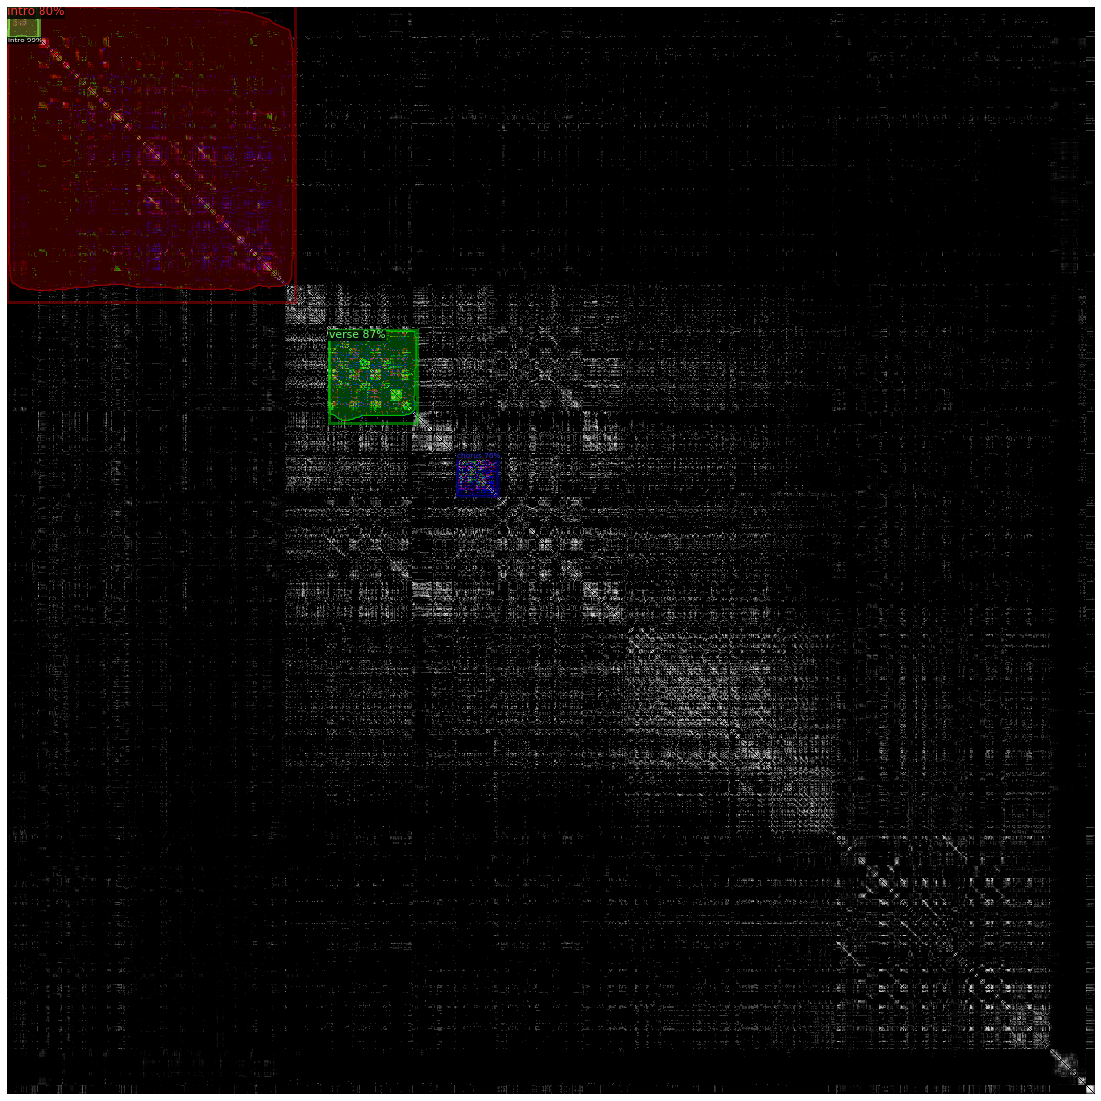

/home/shared/cuzokwe/val//images/630.png
Instances(num_instances=27, image_height=893, image_width=893, fields=[pred_boxes: Boxes(tensor([[2.6239e+02, 4.2394e+02, 3.2814e+02, 4.9547e+02],
        [6.2324e+02, 6.1992e+02, 7.4817e+02, 7.4858e+02],
        [3.2463e+02, 3.2873e+02, 4.1173e+02, 4.1521e+02],
        [3.2502e+02, 1.6279e+02, 4.1359e+02, 2.5397e+02],
        [6.2021e+02, 4.2516e+02, 6.8628e+02, 4.9360e+02],
        [4.2871e+02, 6.2017e+02, 4.9076e+02, 6.8586e+02],
        [4.2145e+02, 2.5917e+02, 4.8893e+02, 3.2645e+02],
        [2.7702e-01, 6.2409e-01, 4.3946e+01, 4.3334e+01],
        [1.6889e+02, 3.2928e+02, 2.5748e+02, 4.2474e+02],
        [6.9398e+02, 4.2757e+02, 7.5104e+02, 4.9282e+02],
        [1.4551e+02, 1.4947e+02, 2.5276e+02, 2.5911e+02],
        [1.6574e+02, 5.2600e+02, 2.5419e+02, 6.2044e+02],
        [9.9092e+01, 4.2750e+02, 1.6547e+02, 4.8944e+02],
        [8.1268e+02, 8.3411e-02, 8.8735e+02, 4.5977e+01],
        [2.5336e+02, 6.1631e+02, 3.2874e+02, 6.8121e+02],


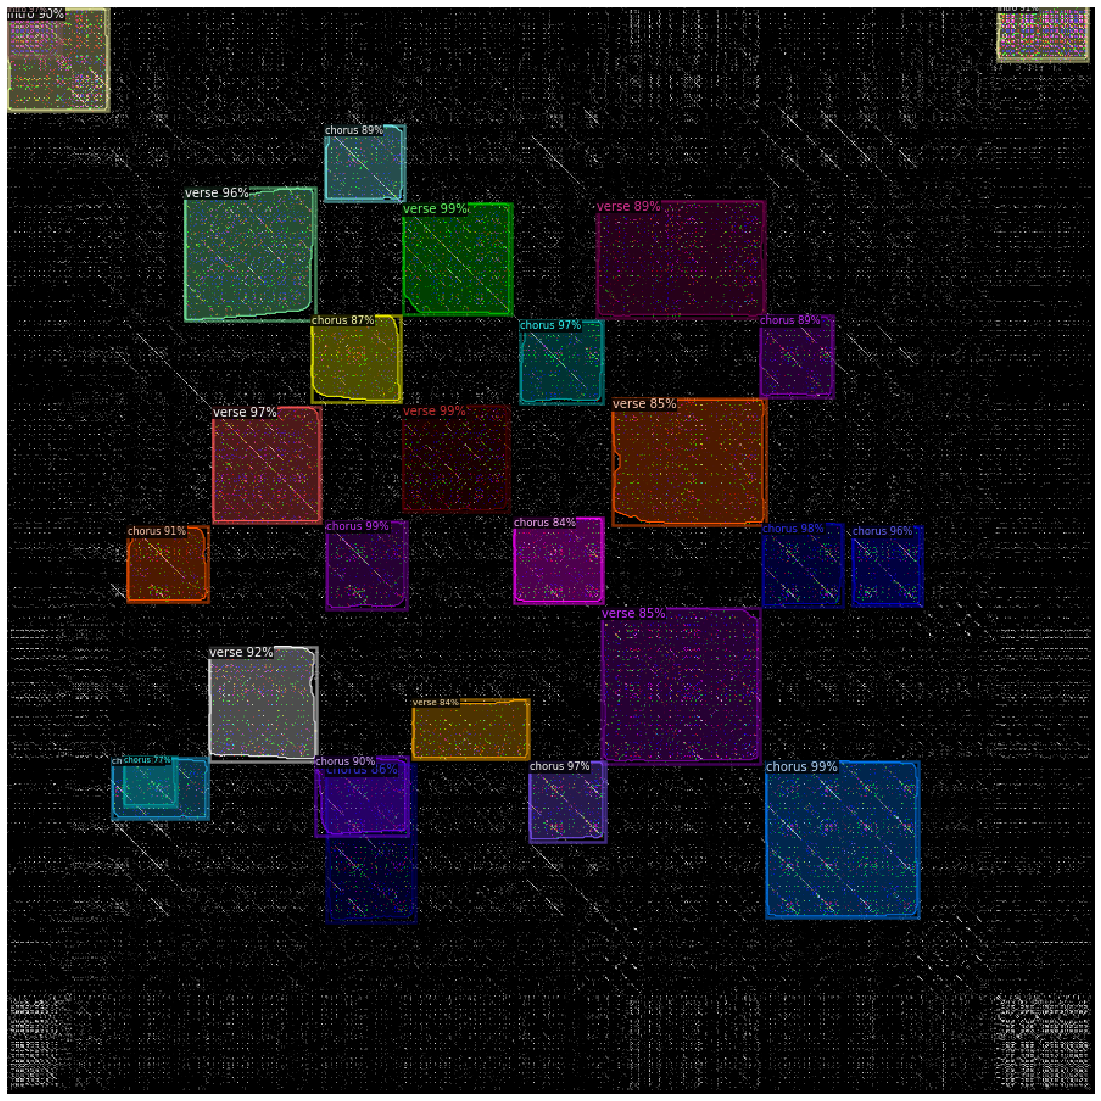

In [39]:
## fix this up (images), and try 

from detectron2.utils.visualizer import ColorMode
for d in random.sample(dataset_dicts_val, 2):    
    im = cv2.imread(d["file_name"])
    print(d["file_name"])
    outputs = predictor(im)
    print(outputs["instances"])
    v = Visualizer(im[:, :, ::-1],
                   metadata=audio_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(20,20))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

In [17]:
Another small thing to remember: detectron2 models do not support model.to(device) or model.cpu(). The device is defined in cfg.MODEL.DEVICE and cannot be changed afterwards.

SyntaxError: invalid syntax (<ipython-input-17-e2e25a677cfb>, line 1)